Libraries:

TODO: Unbedingt ansehen wie in R Zeile 122 target_out nicht gescalt wird! Den in meinem Notebook wird es aktuell..

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Read the data and use the date column as the rownamees/index

In [31]:
raw_data = pd.read_csv("./data/btc_hist.csv")
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.set_index('Date', inplace=True)
raw_data.sort_index(inplace=True)

Get an overview of the data:

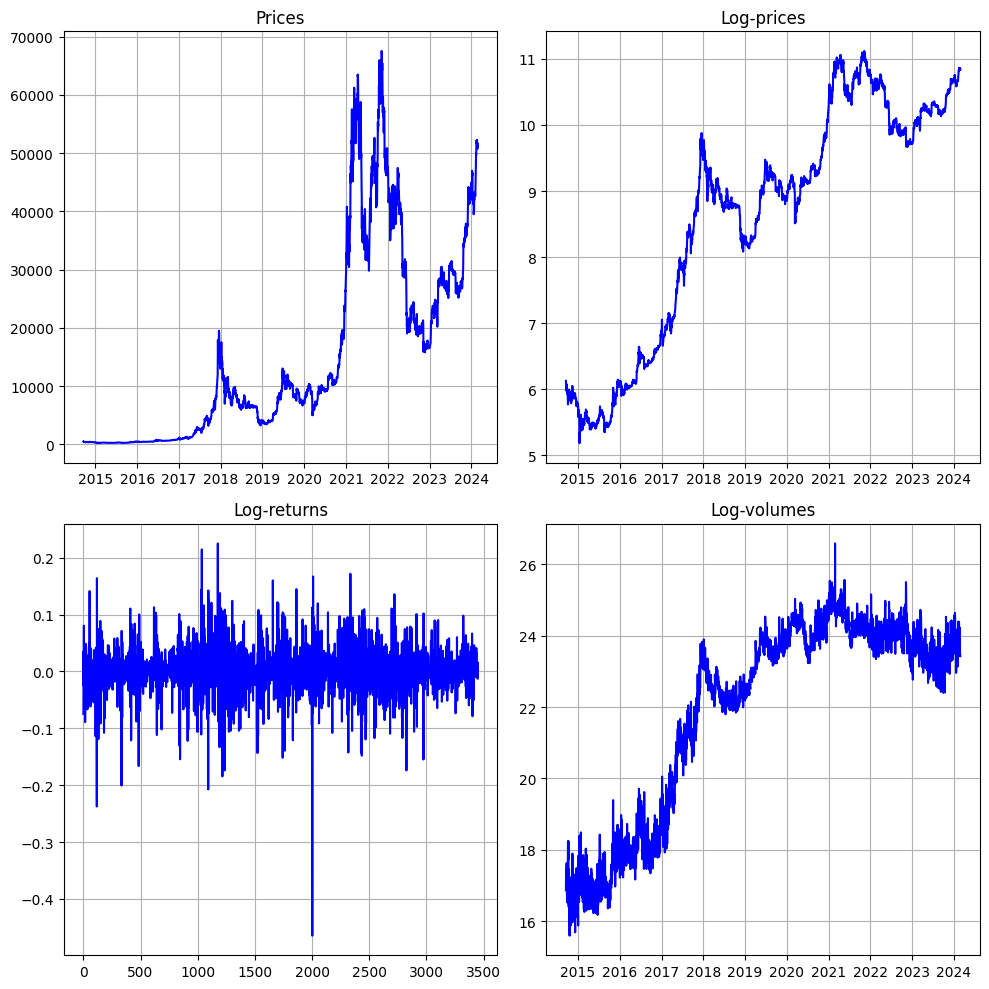

In [32]:
# Set up the matplotlib figure and axes for a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Prices
axs[0, 0].plot(raw_data['Close'], color='blue')
axs[0, 0].grid(True)
axs[0, 0].set_title('Prices')

# Log-prices
axs[0, 1].plot(np.log(raw_data['Close']), color='blue')
axs[0, 1].grid(True)
axs[0, 1].set_title('Log-prices')

# Log-returns
axs[1, 0].plot(np.diff(np.log(raw_data['Close'])), color='blue')
axs[1, 0].grid(True)
axs[1, 0].set_title('Log-returns')

# Log-volumes
axs[1, 1].plot(np.log(raw_data['Volume']), color='blue')
axs[1, 1].grid(True)
axs[1, 1].set_title('Log-volumes')

# Adjust layout to not overlap and show the plots
plt.tight_layout()
plt.show()

Have a look at the ACF, the ACF function in R seems more rewarding to me..

In [33]:
# Calculate the ACF
x_fit = np.diff(np.log(raw_data["Close"]))
#acf_values = acf(x_fit, nlags = 1000)
#plot_acf(acf_values[1:], lags = 30)
#plt.acorr(x_fit,usevlines=True, normed=True, maxlags=50, lw=2)

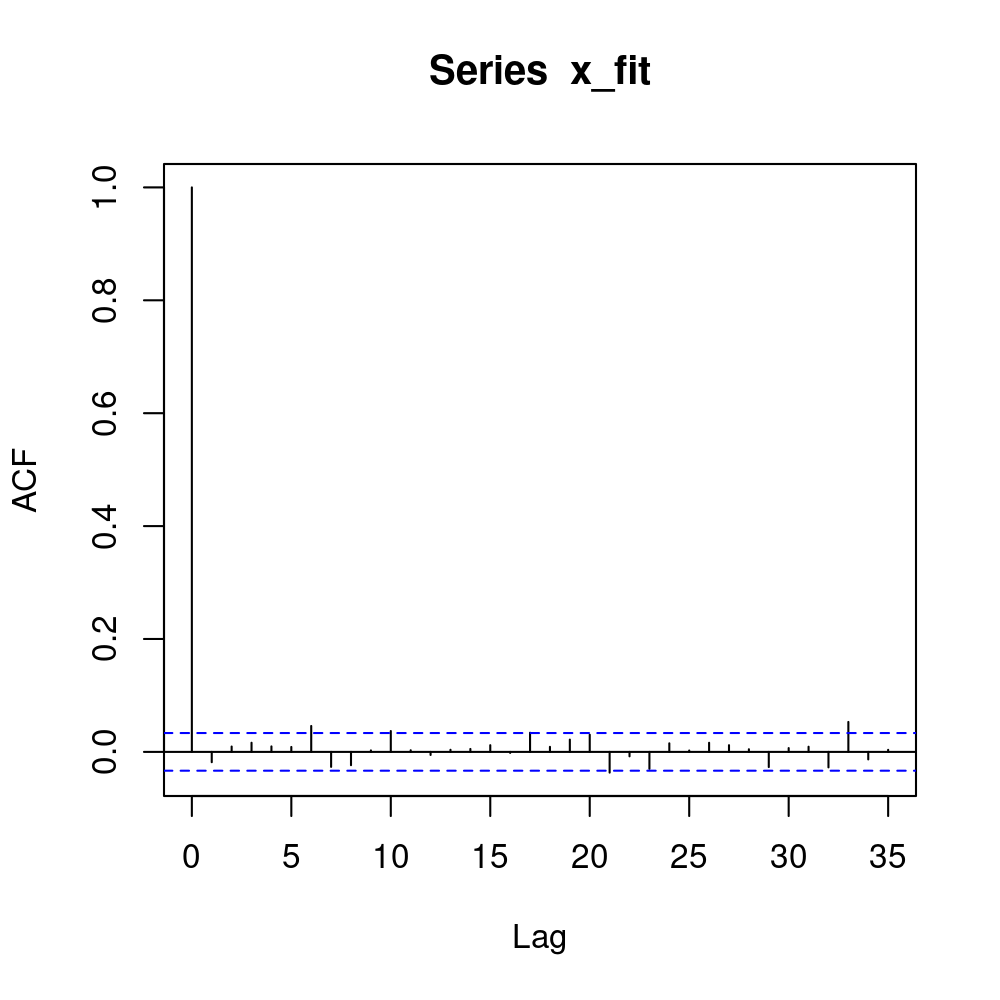

In [34]:
%%R  -i x_fit -w 5 -h 5 --units in -r 200
# -i = import x_fit from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
acf(x_fit)

Specify target and explanatory data: we use first six/seven lags based on above data analysis?

In [35]:
x = np.diff(np.log(raw_data['Close']))
x = pd.DataFrame(x, index=raw_data.index[1:], columns=['Close'])
# Creating lagged versions of x
lags = [x.shift(i) for i in range(7)]  # Generates shifted versions of x from 0 to 6

# Concatenating the lagged versions along axis=1 (columns)
data = pd.concat(lags, axis=1)

# Name the columns to reflect their lag
data.columns = ['Lag_' + str(i) for i in range(7)]
print('Dimensions of the df b4 na removal:',data.shape)
data = data.dropna()
print('Dimensions of the df after na removal:', data.shape)
data.head()

Dimensions of the df b4 na removal: (3449, 7)
Dimensions of the df after na removal: (3443, 7)


,Lag_0,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6
Date,,,,,,,
2014-09-24 00:00:00+00:00,-0.029306,0.080333,0.008317,-0.024968,0.035111,-0.072402,-0.074643
2014-09-25 00:00:00+00:00,-0.027868,-0.029306,0.080333,0.008317,-0.024968,0.035111,-0.072402
2014-09-26 00:00:00+00:00,-0.017523,-0.027868,-0.029306,0.080333,0.008317,-0.024968,0.035111
2014-09-27 00:00:00+00:00,-0.012202,-0.017523,-0.027868,-0.029306,0.080333,0.008317,-0.024968
2014-09-28 00:00:00+00:00,-0.057539,-0.012202,-0.017523,-0.027868,-0.029306,0.080333,0.008317


Specify in- and out-of-sample episodes as well as the target and explanatory variables: Lag_0 is the target and the others are the explanatory variables.

In [162]:
def split_dataset_by_years(data, train_years=None, test_years=None, separator_date=None):
    """
    Split the dataset into training and testing sets based on specified years and a separator date.

    Parameters:
    - data (pd.DataFrame): The full dataset containing both the target and explanatory variables. The dataset must have a DateTimeIndex.
    - train_years (list of int): The years for which the data should be used for training.
    - test_years (list of int): The year / years for which the data should be used for testing.
    - separator_date (str): The cutoff date in 'YYYY-MM-DD' format to separate training and testing data within the year.

    Returns:
    - train (pd.DataFrame): The training dataset, containing observations for the specified training years up to the separator date.
    - test (pd.DataFrame): The testing dataset, containing observations for the specified testing year from the separator date onwards.
    - target_in (pd.Series): Target variable(s) for the training dataset.
    - target_out (pd.Series): Target variable(s) for the testing dataset.
    """
    if train_years is None or test_years is None:
        unique_years = sorted(data.index.year.unique())
        if train_years is None:
            train_years = unique_years[:-2]  # Default to all but the last two years
        if test_years is None:
            test_years = unique_years[-2:]  # Default to the last two years
            
    if not isinstance(train_years, list):
        train_years = [train_years]
    if not isinstance(test_years, list):
        test_years = [test_years]
        
    # Convert separator_date from string to datetime if provided
    if separator_date:
        separator_date = pd.to_datetime(separator_date)
        train_filter = data[(data.index.year.isin(train_years)) & (data.index < separator_date)]
        test_filter = data[(data.index.year.isin(test_years)) & (data.index >= separator_date)]
    else:
        train_filter = data[data.index.year.isin(train_years)]
        test_filter = data[data.index.year.isin(test_years)]
    
    # Further split into target and explanatory variables
    target_in = train_filter.iloc[:, 0]
    explanatory_in = train_filter.iloc[:, 1:]
    target_out = test_filter.iloc[:, 0]
    explanatory_out = test_filter.iloc[:, 1:] 

    train = pd.concat([target_in, explanatory_in], axis=1)
    test = pd.concat([target_out, explanatory_out], axis=1)

    return train, test, target_in, target_out

train, test, target_in, target_out = split_dataset_by_years(data,[2022],[2023])
# Challenge with leap year, due to 29th of January..


Scaling the data so we can feed it into our ML-Process:

In [163]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
train_scaled= scaler.fit_transform(train)
# Convert scaled data back to df
train = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)

test_scaled = scaler.fit_transform(test)
test = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)

# To verify the scaling, you can check the min and max values now
print("Min values after scaling:\n", test.min())
print("Max values after scaling:\n", test.max())

Min values after scaling:
 Lag_0    0.0
Lag_1    0.0
Lag_2    0.0
Lag_3    0.0
Lag_4    0.0
Lag_5    0.0
Lag_6    0.0
dtype: float64
Max values after scaling:
 Lag_0    1.0
Lag_1    1.0
Lag_2    1.0
Lag_3    1.0
Lag_4    1.0
Lag_5    1.0
Lag_6    1.0
dtype: float64


In [164]:
def prepare_and_train_SVR(train, test):
    """
    Separates the provided training and testing datasets into explanatory and target variables,
    trains a Support Vector Regression (SVR) model on the training data, and prints the shapes of the datasets.

    Parameters:
    - train (pd.DataFrame): Training dataset containing both the target variable 'Lag_0' and explanatory variables.
    - test (pd.DataFrame): Testing dataset containing both the target variable 'Lag_0' and explanatory variables.

    Returns:
    - 
    """
    X_train = train.drop(columns=['Lag_0']) # Explanatory
    y_train = train["Lag_0"] # Target
    
    X_test = test.drop(columns=['Lag_0'])
    y_test = test["Lag_0"]
    
    print(f"Shape of the sets:\nX_train:{X_train.shape}\nX_test:{X_test.shape}\ny_train:{y_train.shape}\ny_test:{y_test.shape}")
    
    regr = svm.SVR() # Support Vector Regression
    regr.fit(X_train, y_train)
    
    y_train_pred_scaled = regr.predict(X_train) # Scaled
    y_test_pred_scaled = regr.predict(X_test) # Scaled
    
    y_train_pred = y_train_pred_scaled * (max(data["Lag_0"]) - min(data["Lag_0"]))+ min(data['Lag_0']) # Descaled
    y_test_pred = y_test_pred_scaled *  (max(data["Lag_0"]) - min(data["Lag_0"]))+ min(data['Lag_0']) # Descaled
    
    return y_train, y_test, y_train_pred ,y_test_pred, y_test_pred_scaled, y_train_pred_scaled

y_train, y_test, y_train_pred, y_test_pred, y_test_pred_scaled, y_train_pred_scaled = prepare_and_train_SVR(train=train, test=test)

Shape of the sets:
X_train:(365, 6)
X_test:(365, 6)
y_train:(365,)
y_test:(365,)


Here we have to transform the data back to have a proper look at the prediciton!
Let's do this in the next step

# MSE Evaluation


In [165]:
MSE_in = np.mean(((y_train - y_train_pred_scaled) * (max(data["Lag_0"])-min(data["Lag_0"])))**2)
MSE_out = np.mean(((y_test - y_test_pred_scaled) * (max(data["Lag_0"])-min(data["Lag_0"])))**2)    

print(f"This is our MSE for the SVR in-sample: {MSE_in}")
print(f"This is our MSE for the SVR out-of-sample: {MSE_out}")
# Further inspect the MSE, have a plot of the forecasts! Try to interpret and use a benchmark e.g 0

This is our MSE for the SVR in-sample: 0.003766681687438912
This is our MSE for the SVR out-of-sample: 0.012078724067271392


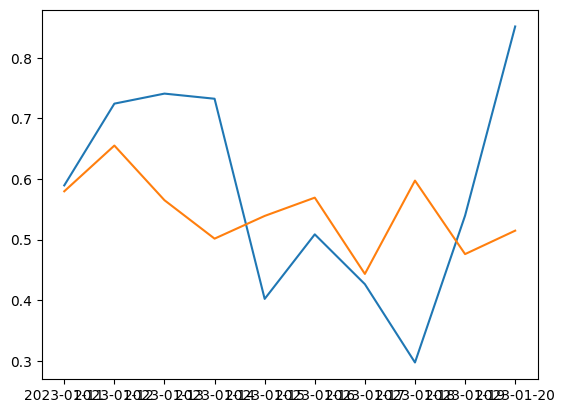

In [173]:
y_test_pred_scaled = pd.DataFrame(y_test_pred_scaled)
y_test_pred_scaled.index = y_test.index

plt.plot(y_test[10:20])
plt.plot(y_test_pred_scaled[10:20])



# Trading Performance:

In [167]:
def remove_leap_day(df):
    """
    Removes February 29th from the dataset if present, to avoid leap year issues.
    
    Parameters:
    - df (pd.DataFrame or pd.Series): Dataset with DateTimeIndex.
    
    Returns:
    - Updated dataset without February 29th.
    """
    return df[~((df.index.month == 2) & (df.index.day == 29))]

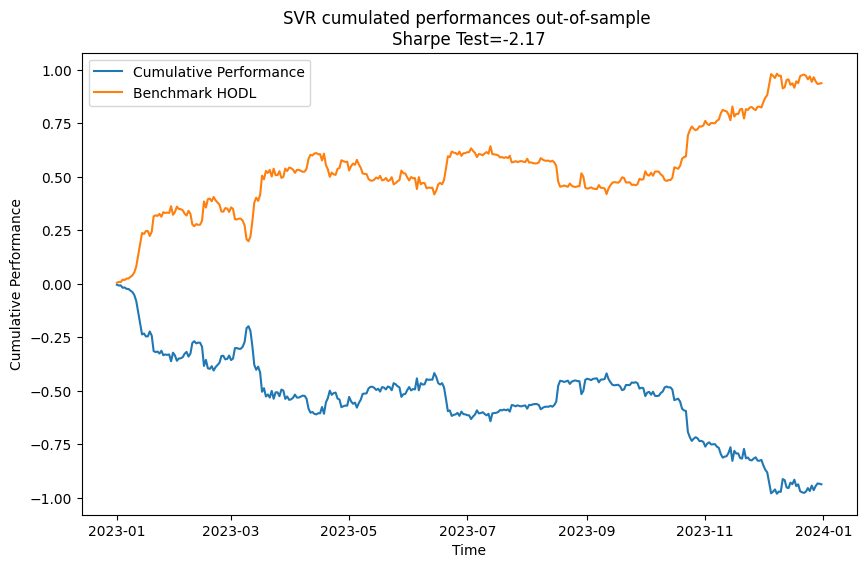

In [168]:
def plot_performance(y_test_pred, target_out, target_in):
    """
    Plot the cumulative performance of predictions made by a Support Vector Regression (SVR) model.
    
    Parameters:
    - y_test_pred (array-like): Predictions made by the SVR model. These are expected to be numerical values.
    - target_out (pandas.Series): Actual target values corresponding to the predictions for out-of-sample data. The Series index must be a DatetimeIndex.
    - target_in (pandas.Series): Actual target values for in-sample data used for training the SVR model. The Series index must be a DatetimeIndex.

    This function calculates the performance as the product of the sign of the predictions and the actual target values. It then computes the Sharpe ratio as a measure of risk-adjusted return and plots the cumulative performance over time. The plot is saved to a file named after the first and last dates of the target indices.

    Returns:
    None. The function creates a plot and saves it as a PNG file in the './img/' directory.

    Side Effects:
    - Saves a plot to the filesystem in the specified directory.
    """
    # Ensure alignment by removing February 29th
#    target_out = remove_leap_day(target_out)
#    target_in = remove_leap_day(target_in)
    
    if len(y_test_pred) != len(target_out):
        raise ValueError("y_test_pred and target_out length mismatch. Check for leap year issues.")
    
    perf_svr = np.sign(y_test_pred)*target_out
    #perf_svr_in = np.sign(y_train_pred) * target_in
    
    sharpe_svr = np.sqrt(len(target_out)) * perf_svr.mean()/ perf_svr.std() # Or do we have to put 365?
    #sharpe_svr_in = np.sqrt(len(target_in)) * perf_svr.mean()/ perf_svr.std() # can i do that with the len?
    
    cumulative_perf_svr = np.cumsum(perf_svr)
    #cumulative_perf_svr_in = np.cumsum(perf_svr_in)
    
    first_date = target_in.index[0]
    last_date =  target_out.index[-1]
    nomenclature = f"{first_date.strftime('%Y-%m-%d')}_to_{last_date.strftime('%Y-%m-%d')}"
    
    # Plotting
    plt.figure(figsize=(10, 6))  # Set the figure size (optional)
    plt.plot(cumulative_perf_svr, label='Cumulative Performance')
    plt.plot(np.cumsum(target_out), label = "Benchmark HODL")
    plt.title(f"SVR cumulated performances out-of-sample \nSharpe Test={round(sharpe_svr, 2)}")
    plt.xlabel('Time')
    plt.ylabel('Cumulative Performance')
    plt.legend()
    plt.savefig(f"./img/{nomenclature}.png")
    plt.show()
        
plot_performance(y_test_pred, target_out, target_in)


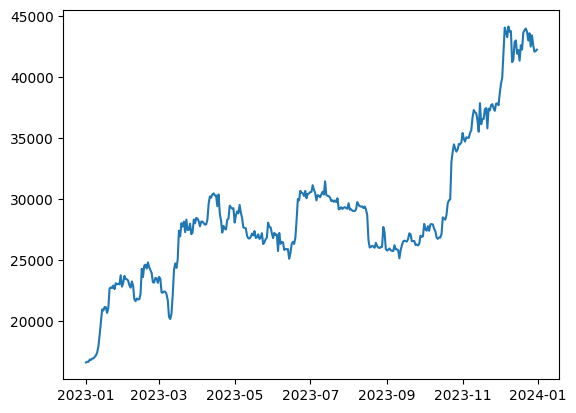

In [170]:
plt.plot(raw_data["Close"][ raw_data.index.year == 2023])

# Benchmark HODL

In [156]:
target_out
#plt.plot(np.cumsum(target_out))

Date
2020-01-01 00:00:00+00:00    0.000914
2020-01-02 00:00:00+00:00   -0.030273
2020-01-03 00:00:00+00:00    0.050172
2020-01-04 00:00:00+00:00    0.008915
2020-01-05 00:00:00+00:00    0.000089
                               ...   
2020-12-27 00:00:00+00:00   -0.006251
2020-12-28 00:00:00+00:00    0.030458
2020-12-29 00:00:00+00:00    0.010198
2020-12-30 00:00:00+00:00    0.052625
2020-12-31 00:00:00+00:00    0.005559
Name: Lag_0, Length: 366, dtype: float64

Backtransformation:

In [45]:
y_test_descaled = y_test_pred * (max(data["Lag_0"]) - min(data["Lag_0"]))+ min(data['Lag_0'])
y_train_descaled = y_train_pred * (max(data["Lag_0"])-min(data["Lag_0"]))+min(data["Lag_0"])

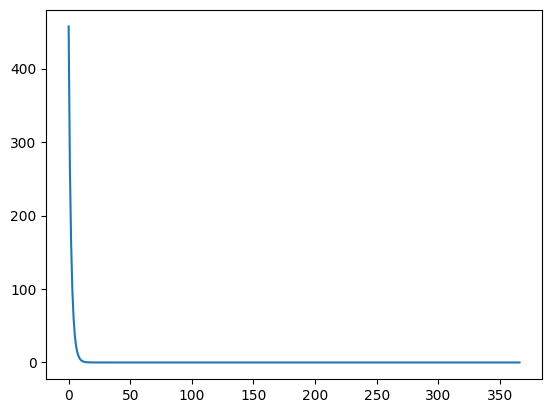

In [46]:
exp_x_pred = np.exp(y_train_descaled)

# To correctly reverse the operation, we need the initial value before diff and log were applied
initial_value = raw_data['Close'].iloc[0]  # the initial value is the first value of the Close

# Since np.exp(x) reverses the log, and the cumulative sum will give the relative changes,
# you need to adjust the cumulative product to start with the initial value of the original series.
reversed_pred = np.cumprod(np.insert(exp_x_pred, 0, initial_value))

exp_y_test = np.exp(y_test_descaled)
reversed_y_test = np.cumprod(np.insert(exp_y_test, 0, initial_value))

exp_y_train = np.exp(target_out)
reversed_y_train = np.cumprod(np.insert(exp_y_train, 0, initial_value))
plt.plot(reversed_y_test)
#plt.plot(raw_data["Close"])

In [47]:
#plt.plot(np.cumsum(exp_x_pred))
np.exp(y_train_descaled)

array([0.60060015, 0.5863034 , 0.60242816, 0.58892207, 0.63217602,
       0.60536424, 0.60220039, 0.58363781, 0.59791515, 0.59351442,
       0.60875182, 0.60873513, 0.53764979, 0.47819722, 0.69983047,
       0.60760137, 0.60204894, 0.61434017, 0.60753901, 0.60444242,
       0.62690744, 0.60802017, 0.63002948, 0.6202107 , 0.60954712,
       0.62964187, 0.60627617, 0.5503412 , 0.61604627, 0.60272545,
       0.60418559, 0.6067894 , 0.6101555 , 0.58784609, 0.57493332,
       0.6016803 , 0.61332153, 0.62206587, 0.61253619, 0.57702284,
       0.59288204, 0.60060812, 0.61757804, 0.61205553, 0.6322522 ,
       0.56858139, 0.5882078 , 0.62181955, 0.61139378, 0.59380454,
       0.58610523, 0.59895998, 0.60417146, 0.61022118, 0.60758655,
       0.61338176, 0.60972432, 0.59996209, 0.62771034, 0.60509418,
       0.6170149 , 0.6123097 , 0.60110235, 0.62400918, 0.61685523,
       0.61209211, 0.62762888, 0.61424984, 0.63162549, 0.61777589,
       0.61274288, 0.60924546, 0.61132208, 0.60989555, 0.60853

In [48]:
print(f"This is our MSE for the SVR out of sample: {mean_squared_error(reversed_y_test, reversed_pred)}")
print(reversed_y_test.shape)
print(reversed_pred.shape)

ValueError: Found input variables with inconsistent numbers of samples: [367, 366]